In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import pickle

In [2]:
df_feat = pd.read_csv('../encoded data/opamps-features.csv')
df_ref = pd.read_csv('../encoded data/opamps-xref.csv')

In [3]:
df_stm = df_ref.merge(df_feat , left_on=["STMicro MPN","STMicro Name"], right_on=["MPN",	"MANUFACTURER"	])
df_merged = df_stm.merge(df_feat , left_on=["Competitor MPN","Competitor Name"], right_on=["MPN",	"MANUFACTURER"	], suffixes = ("","_comp") )
df_merged.drop(columns=["STMicro MPN","STMicro Name", "Competitor MPN","Competitor Name"],inplace = True)
df_merged.head()

,Cross Reference Type,MPN,MANUFACTURER,Maximum Input Offset Voltage,Maximum Single Supply Voltage,Minimum Single Supply Voltage,Number of Channels per Chip,Supplier_Package,Typical Gain Bandwidth Product,MPN_comp,MANUFACTURER_comp,Maximum Input Offset Voltage_comp,Maximum Single Supply Voltage_comp,Minimum Single Supply Voltage_comp,Number of Channels per Chip_comp,Supplier_Package_comp,Typical Gain Bandwidth Product_comp
0,A,PN-1017594,MN-1030,0.002,30.0,3.0,1.0,SOT-23,800000.0,PN-1017599,MN-1036,0.004,30.0,3.0,1.0,SOT-23,800000.0
1,A,PN-1017602,MN-1030,0.004,30.0,3.0,1.0,SOT-23,800000.0,PN-1017598,MN-1036,0.004,30.0,3.0,1.0,SOT-23,800000.0
2,A,PN-1017602,MN-1030,0.004,30.0,3.0,1.0,SOT-23,800000.0,PN-1017597,MN-1036,0.004,30.0,3.0,1.0,SOT-23,800000.0
3,A,PN-1017594,MN-1030,0.002,30.0,3.0,1.0,SOT-23,800000.0,PN-1017598,MN-1036,0.004,30.0,3.0,1.0,SOT-23,800000.0
4,A,PN-1017602,MN-1030,0.004,30.0,3.0,1.0,SOT-23,800000.0,PN-1017599,MN-1036,0.004,30.0,3.0,1.0,SOT-23,800000.0


In [5]:
test  = df_feat.merge(df_feat, on=["MPN",	"MANUFACTURER"],suffixes = ("","_comp"))
test["MPN_comp"]= test["MPN"]
test["MANUFACTURER_comp"]= test["MANUFACTURER"]
test["Cross Reference Type"] = "A"
test = test.reindex(['Cross Reference Type', 'MPN', 'MANUFACTURER',
       'Maximum Input Offset Voltage', 'Maximum Single Supply Voltage',
       'Minimum Single Supply Voltage', 'Number of Channels per Chip',
       'Supplier_Package', 'Typical Gain Bandwidth Product', 'MPN_comp',
       'MANUFACTURER_comp', 'Maximum Input Offset Voltage_comp',
       'Maximum Single Supply Voltage_comp',
       'Minimum Single Supply Voltage_comp',
       'Number of Channels per Chip_comp', 'Supplier_Package_comp',
       'Typical Gain Bandwidth Product_comp'],axis=1)
test['Cross Reference Type'].value_counts()

Cross Reference Type
A    18352
Name: count, dtype: int64

In [6]:
df_merged = pd.concat([df_merged,test])
df_merged["Cross Reference Type"].value_counts()

Cross Reference Type
D              808455
C              158650
B               36764
A               18360
C/Upgrade         465
C/Downgrade       336
B/Downgrade       114
B/Upgrade          48
SF                  7
Name: count, dtype: int64

In [7]:
df_merged["Cross Reference Type"] = df_merged["Cross Reference Type"].replace("B/Downgrade","B")
df_merged["Cross Reference Type"] = df_merged["Cross Reference Type"].replace("B/Upgrade","B")
df_merged["Cross Reference Type"] = df_merged["Cross Reference Type"].replace("C/Downgrade","C")
df_merged["Cross Reference Type"] = df_merged["Cross Reference Type"].replace("C/Upgrade","C")

In [8]:
df_merged["Cross Reference Type"].value_counts()
df_filtered = df_merged[~df_merged["Cross Reference Type"].isin(["SF"])] # à rectifier avec l'equipe de données
df_filtered["Cross Reference Type"].value_counts()

Cross Reference Type
D    808455
C    159451
B     36926
A     18360
Name: count, dtype: int64

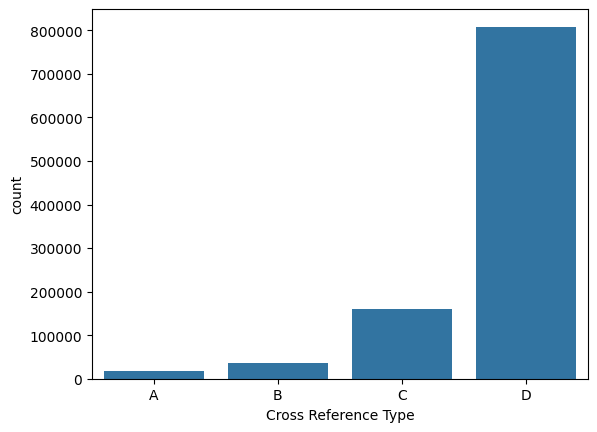

In [10]:
sns.countplot(df_filtered, x="Cross Reference Type")
plt.show()

In [12]:

from scipy.stats import norm
base_means = {
    'A': 0.96,
    'B': 0.84,
   # 'C': 0.71,
   'C': 0.65,
    #'D':0.59 # 0.55, 0.65
    'D':0.5
}
base_std={
    'A': 0.0107,
    'B': 0.0249,
    'C': 0.01779,
    'D': 0.01779
}
interval= {
    "A":(0.93,1),
    "B": (0.77,0.92),
    #"C":(0.66,0.76),
    "C":(0.60,0.71),
    #"D":(0.55,0.65)
    "D":(0.44,0.56)
}
def get_params(category):
    parts = category.split('/')
    
    mean = base_means.get(parts[0], 0.0)
    std = base_std.get(parts[0], 0.0)
    return mean, std
df_filtered["Mean"] , df_filtered["Std"] = zip(*df_filtered["Cross Reference Type"].map(get_params))
df_filtered['Closeness'] = df_filtered.apply(lambda row: norm.rvs(loc=row['Mean'], scale=row['Std']), axis=1)
df_filtered['Closeness'] = df_filtered['Closeness'].clip(0, 1)
for classe in interval:
    df_filtered.loc[df_filtered["Cross Reference Type"]==classe, "Closeness"] = df_filtered.loc[df_filtered["Cross Reference Type"]==classe, "Closeness"].clip(*interval[classe])


C:\Users\adamg\AppData\Local\Temp\ipykernel_33456\2468981313.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Mean"] , df_filtered["Std"] = zip(*df_filtered["Cross Reference Type"].map(get_params))
C:\Users\adamg\AppData\Local\Temp\ipykernel_33456\2468981313.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Mean"] , df_filtered["Std"] = zip(*df_filtered["Cross Reference Type"].map(get_params))
C:\Users\adamg\AppData\Local\Temp\ipykernel_33456\2468981313.py:31: SettingWithCop

<Axes: xlabel='Closeness', ylabel='Density'>

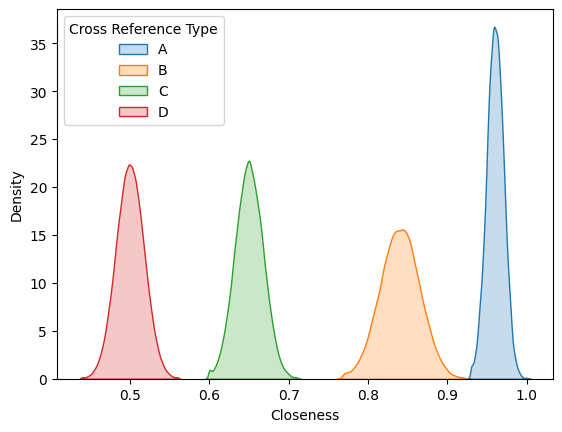

In [13]:
sns.kdeplot(data=df_filtered, x='Closeness', hue='Cross Reference Type', fill=True, common_norm=False)


In [22]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1023192 entries, 0 to 18351
Data columns (total 20 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   Cross Reference Type                 1023192 non-null  object 
 1   MPN                                  1023192 non-null  object 
 2   MANUFACTURER                         1023192 non-null  object 
 3   Maximum Input Offset Voltage         1023192 non-null  float64
 4   Maximum Single Supply Voltage        1023192 non-null  float64
 5   Minimum Single Supply Voltage        1023192 non-null  float64
 6   Number of Channels per Chip          1023192 non-null  float64
 7   Supplier_Package                     1023192 non-null  object 
 8   Typical Gain Bandwidth Product       1023192 non-null  float64
 9   MPN_comp                             1023192 non-null  object 
 10  MANUFACTURER_comp                    1023192 non-null  object 
 11  Maxim

In [16]:
df_filtered.columns

Index(['Cross Reference Type', 'MPN', 'MANUFACTURER',
       'Maximum Input Offset Voltage', 'Maximum Single Supply Voltage',
       'Minimum Single Supply Voltage', 'Number of Channels per Chip',
       'Supplier_Package', 'Typical Gain Bandwidth Product', 'MPN_comp',
       'MANUFACTURER_comp', 'Maximum Input Offset Voltage_comp',
       'Maximum Single Supply Voltage_comp',
       'Minimum Single Supply Voltage_comp',
       'Number of Channels per Chip_comp', 'Supplier_Package_comp',
       'Typical Gain Bandwidth Product_comp', 'Mean', 'Std', 'Closeness'],
      dtype='object')

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder


In [29]:
class CustomVectorDataset(Dataset):
    def __init__(self, dataframe, vector1_columns, vector2_columns, target_column, categorical_columns=[]):
        """
        Args:
            dataframe (pd.DataFrame): The DataFrame containing the data.
            vector1_columns (list): List of column names for the first vector.
            vector2_columns (list): List of column names for the second vector.
            target_column (str): The column name for the target value.
            categorical_columns (list): List of column names that are categorical.
        """
        self.dataframe = dataframe.copy()
        self.vector1_columns = vector1_columns
        self.vector2_columns = vector2_columns
        self.target_column = target_column
        self.categorical_columns = categorical_columns
        
        # Label encode categorical columns
        self.label_encoders = {}
        for col in self.categorical_columns:
            le = LabelEncoder()
            self.dataframe[col] = le.fit_transform(self.dataframe[col])
            self.label_encoders[col] = le
        
        # Convert columns to tensors
        self.vector1 = torch.tensor(self.dataframe[vector1_columns].values, dtype=torch.float32)
        self.vector2 = torch.tensor(self.dataframe[vector2_columns].values, dtype=torch.float32)
        self.target = torch.tensor(self.dataframe[target_column].values, dtype=torch.float32).unsqueeze(1)
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        vector1 = self.vector1[idx]
        vector2 = self.vector2[idx]
        target = self.target[idx]
        return vector1, vector2, target

In [30]:
columns_1 = ['MPN', 'MANUFACTURER',
       'Maximum Input Offset Voltage', 'Maximum Single Supply Voltage',
       'Minimum Single Supply Voltage', 'Number of Channels per Chip',
       'Supplier_Package', 'Typical Gain Bandwidth Product']
columns_2 = ['MPN_comp',
       'MANUFACTURER_comp', 'Maximum Input Offset Voltage_comp',
       'Maximum Single Supply Voltage_comp',
       'Minimum Single Supply Voltage_comp',
       'Number of Channels per Chip_comp', 'Supplier_Package_comp',
       'Typical Gain Bandwidth Product_comp']
categorical_columns=['MPN', 'MANUFACTURER','Supplier_Package','MPN_comp',
       'MANUFACTURER_comp','Supplier_Package_comp']

In [59]:
torch.manual_seed(42)
dataset_train = CustomVectorDataset(df_filtered,columns_1,columns_2, 'Closeness',categorical_columns=categorical_columns)
dataloader = DataLoader(dataset_train, batch_size=1, shuffle=True)

In [60]:
vec1,vec2,target = next(iter(dataloader))

In [61]:
vec1

tensor([[8.7980e+03, 2.4000e+01, 8.0000e-04, 5.5000e+00, 1.5000e+00, 2.0000e+00,
         7.1000e+01, 8.8000e+05]])

In [62]:
vec2

tensor([[1.6760e+04, 2.3000e+01, 6.5000e-04, 6.0000e+00, 2.8000e+00, 2.0000e+00,
         1.4000e+01, 5.0000e+07]])

In [63]:
target

tensor([[0.5040]])

In [65]:

class SiameseNetwork(nn.Module):
    def __init__(self, input_dim):
        super(SiameseNetwork, self).__init__()
        self.extract_features_1 = nn.Sequential(nn.Linear(input_dim, 64), nn.ReLU(), nn.Linear(64, 32), nn.ReLU(),nn.Linear(32, 16), nn.ReLU())
        self.extract_features_2 = nn.Sequential(nn.Linear(input_dim, 64), nn.ReLU(), nn.Linear(64, 32), nn.ReLU(),nn.Linear(32, 16), nn.ReLU())
        self.fc4 = nn.Sequential(nn.Linear(32, 16), nn.ReLU(), nn.Linear(16, 8), nn.ReLU(), nn.Linear(8, 1))
        
    def forward(self, input1, input2):
        output1 = self.extract_features_1(input1)
        output2 = self.extract_features_2(input2)
        x = torch.cat((output1, output2), dim=1)
        closeness = self.fc4(x)
        return closeness



In [74]:
torch.cuda.is_available()

True

In [76]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
# Initialize the model, loss function and optimizer
input_dim = len(columns_1)  # Assuming both vectors have the same number of features
model = SiameseNetwork(input_dim).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    print(epoch)
    for vec1, vec2, target in dataloader:
        vec1, vec2, target = vec1.to(device), vec2.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(vec1, vec2)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # print(loss.item())
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")

# Example of using the model for prediction
model.eval()
with torch.no_grad():
    vec1, vec2, target = next(iter(dataloader))
    prediction = model(vec1, vec2)
    print(f"Predicted Closeness: {prediction.item()}, Actual Closeness: {target.item()}")

0
